In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [54]:
data= pd.read_csv("Roszman1_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,0.252429,-4868.68
NaN,0.252141,-4868.09
NaN,0.251809,-4867.41
NaN,0.297989,-3375.19
NaN,0.296257,-3373.14
NaN,0.295319,-3372.03
NaN,0.339603,-2473.74
NaN,0.337731,-2472.35
NaN,0.333820,-2469.45
NaN,0.389510,-1894.65


In [55]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

b = torch.tensor([0.1,-0.00001,1000.0,-100.0],requires_grad=True)
# b = torch.tensor([0.15,0.008,0.01],requires_grad=True)

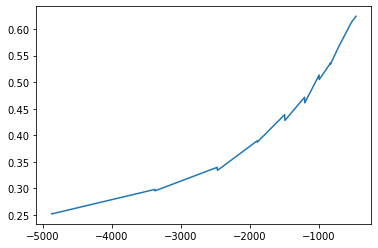

In [56]:
plt.plot(x.numpy(),y.numpy())

In [57]:
## Numerical Differentiation

b = np.array([0.1,-0.00001,1000.0,-100.0]).reshape(-1,1)
# b = np.array([0.7,4]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0

def f0(b0):
    return  b0-b[1]*x - np.arctan(b[2]/(x-b[3]))/np.pi-y.detach().numpy()  
def f1(b1):
    return  b[0]-b1*x - np.arctan(b[2]/(x-b[3]))/np.pi-y.detach().numpy()  
def f2(b2):
    return  b[0]-b[1]*x - np.arctan(b2/(x-b[3]))/np.pi-y.detach().numpy()  
def f3(b3):
    return  b[0]-b[1]*x - np.arctan(b[2]/(x-b3))/np.pi-y.detach().numpy()  

start_time = time.perf_counter()   
    
for c in range(500):

    y_pred = b[0]-b[1]*x - np.arctan(b[2]/(x-b[3]))/np.pi
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    d_b2 = derivative(f2,b[2] , dx=1e-6)
    d_b3 = derivative(f3,b[3] , dx=1e-6)
     
    jacobian = np.transpose(np.array([d_b0,d_b1,d_b2,d_b3]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    
    if V <  4.9484847331E-04:
        break
print("time taken to execute: ",time.perf_counter()-start_time)  
print("SD error is", np.std(np.square(error)))

c:  0  error:  0.5108107497991895  B: [[ 2.47978588e-01]
 [-1.28775223e-05]
 [ 1.00000003e+03]
 [-1.00000032e+02]]
c:  1  error:  0.0006928972394647029  B: [[ 2.49671182e-01]
 [-1.34570737e-05]
 [ 1.00000003e+03]
 [-1.00000032e+02]]
c:  2  error:  0.0006649855964455135  B: [[ 2.49886998e-01]
 [-1.35309704e-05]
 [ 1.00000004e+03]
 [-1.00000031e+02]]
c:  3  error:  0.0006646156319941868  B: [[ 2.49889770e-01]
 [-1.35319225e-05]
 [ 1.00000013e+03]
 [-1.00000018e+02]]
c:  4  error:  0.0006646154184060155  B: [[ 2.49889657e-01]
 [-1.35319124e-05]
 [ 1.00000100e+03]
 [-9.99998908e+01]]
c:  5  error:  0.0006646138841112774  B: [[ 2.49888490e-01]
 [-1.35317999e-05]
 [ 1.00000966e+03]
 [-9.99986206e+01]]
c:  6  error:  0.0006645985438288868  B: [[ 2.49876802e-01]
 [-1.35306683e-05]
 [ 1.00009624e+03]
 [-9.99860592e+01]]
c:  7  error:  0.0006644454063814348  B: [[ 2.49758167e-01]
 [-1.35187964e-05]
 [ 1.00095473e+03]
 [-9.98738849e+01]]
c:  8  error:  0.0006629394997808183  B: [[ 2.48466538e-01]

In [58]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [59]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(200):

    y_pred = b[0]-b[1]*x - torch.atan(b[2]/(x-b[3]))/np.pi

    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error<  4.9484847331E-04:#7.88539786689E+02:  given residual sum of squares
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

TypeError: atan(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
plt.plot(y_pred.detach(),'g', y,'r')